In [1]:
import numpy as np
import xrft
import matplotlib.pyplot as plt
import os
import xarray as xr

from dask.distributed import Client
# client = Client()
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36617,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:37189,Total threads: 4
Dashboard: /proxy/36075/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36651,


In [2]:
basepath = "/home/149/ab8992/bottom_near_inertial_waves/revision/zcoord_doubleprecision"
merid = xr.merge([
    xr.open_mfdataset(f"{basepath}/archive/output0*/e_10min.nc",decode_times = False).isel(xh = 3).e.load(),
    xr.open_mfdataset(f"{basepath}/archive/output0*/u_10min.nc",decode_times = False).isel(xq = 3).u.load(),
    xr.open_mfdataset(f"{basepath}/archive/output0*/v_10min.nc",decode_times = False).isel(xh = 3).v.load(),
    xr.open_mfdataset(f"{basepath}/archive/output0*/pbo_10min.nc",decode_times = False).isel(xh = 3).pbo.load(),
    xr.open_mfdataset(f"{basepath}/archive/output0*/rho_10min.nc",decode_times = False).isel(xh = 3).rho.load()])


merid.to_netcdf(f"{basepath}/archive/merid.nc")
del merid
zonal = xr.merge([
    xr.open_mfdataset(f"{basepath}/archive/output0*/e_10min.nc",decode_times = False).isel(yh = slice(249,251)).mean("yh").e.load(),
    xr.open_mfdataset(f"{basepath}/archive/output0*/u_10min.nc",decode_times = False).isel(yh = slice(249,251)).mean("yh").u.load(),
    xr.open_mfdataset(f"{basepath}/archive/output0*/v_10min.nc",decode_times = False).isel(yq = 250).v.load(),
    xr.open_mfdataset(f"{basepath}/archive/output0*/pbo_10min.nc",decode_times = False).isel(yh = slice(249,251)).mean("yh").pbo.load(),
    xr.open_mfdataset(f"{basepath}/archive/output0*/rho_10min.nc",decode_times = False).isel(yh = slice(249,251)).mean("yh").rho.load()
])

zonal.to_netcdf(f"{basepath}/archive/zonal.nc")


In [2]:
basepath = "/home/149/ab8992/bottom_near_inertial_waves/revision/zcoord_doubleprecision"

merid = xr.open_dataset(f"{basepath}/archive/merid.nc",decode_times = False)
zonal = xr.open_dataset(f"{basepath}/archive/zonal.nc",decode_times = False)

In [13]:
merid["pbo"] = xr.open_mfdataset(f"{basepath}/archive/output0*/pbo_10min.nc",decode_times = False).isel(xh = 3).pbo.load()
merid["rho"] = xr.open_mfdataset(f"{basepath}/archive/output0*/rho_10min.nc",decode_times = False).isel(xh = 3).rho.load()
merid.to_netcdf(f"{basepath}/archive/merid_.nc")


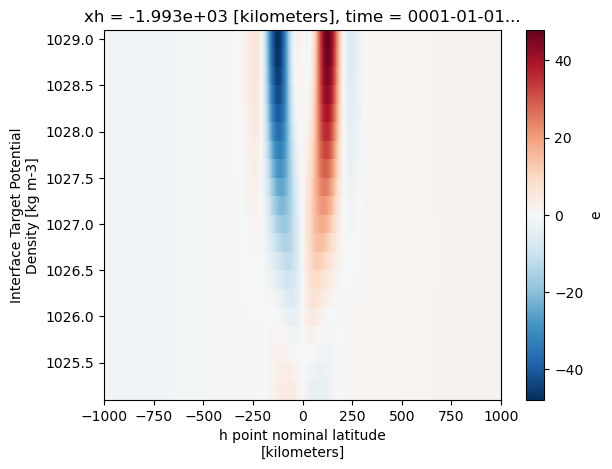

In [14]:
def calculate_pressure_new(e,densities):
    """
    Calculates the pressure at each layer and returns still on the isopycnal layer coordinates. 
    
    """
    nlayers = e.zi.shape[0] - 1
    
    e_0 = e.isel(time = 0)

    e_anom = e - e_0
    
    ref_density = densities.isel(zl = 0)
    anom_densities = densities - ref_density
    
    pressure_anomaly = e.isel(zi = slice(0,nlayers)) * 0

    if "xh" in e.dims:
        pressure_anomaly[:,0,:] =  9.8 * densities.isel(zl = 0) * (e.isel(zi = 0))
        for i in range(1,nlayers):
            pressure_anomaly[:,i,:] = 9.8 * (anom_densities.isel(zl = i)) * (e_anom.isel(zi = i))

    else:
        pressure_anomaly[:,0] =  9.8 * densities.isel(zl = 0) * (e.isel(zi = 0))
        for i in range(1,nlayers):
            pressure_anomaly[:,i] = 9.8 * (anom_densities.isel(zl = i)) * (e_anom.isel(zi = i))
            

    # pressure = pressure_anomaly.cumsum("zi")
    # pressure = pressure_anomaly.sum("zi")
    
    ## This pressure is on isopycnal coordinates. zl level is actually the pressure at the base of the layer 
    pressure = xr.DataArray(
        data = pressure_anomaly.cumsum("zi"),
        dims = e.dims,
        # dims = ["time","zl","xh"],
        # coords = {"time":e.time.values,"zl":densities.zl.values,"xh":e.xh.values})
        coords = e.isel(zi = slice(1,None)).coords).rename({"zi":"zl"})    
    
    return pressure

merid_p = calculate_pressure_new(merid.e,merid.zl)
merid_p.isel(time = 100).plot()

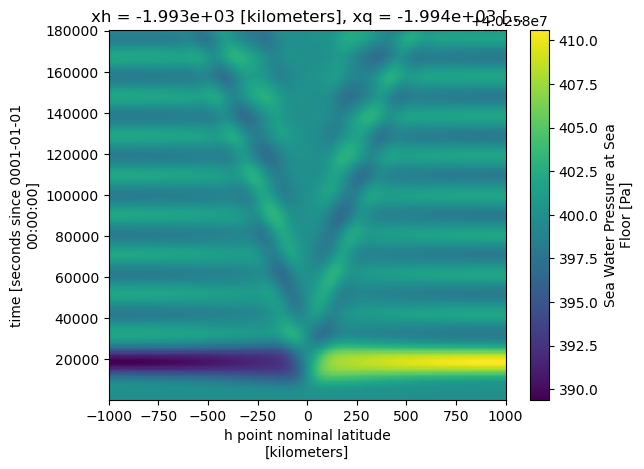

In [70]:
merid.pbo.plot()


<Figure size 640x480 with 0 Axes>

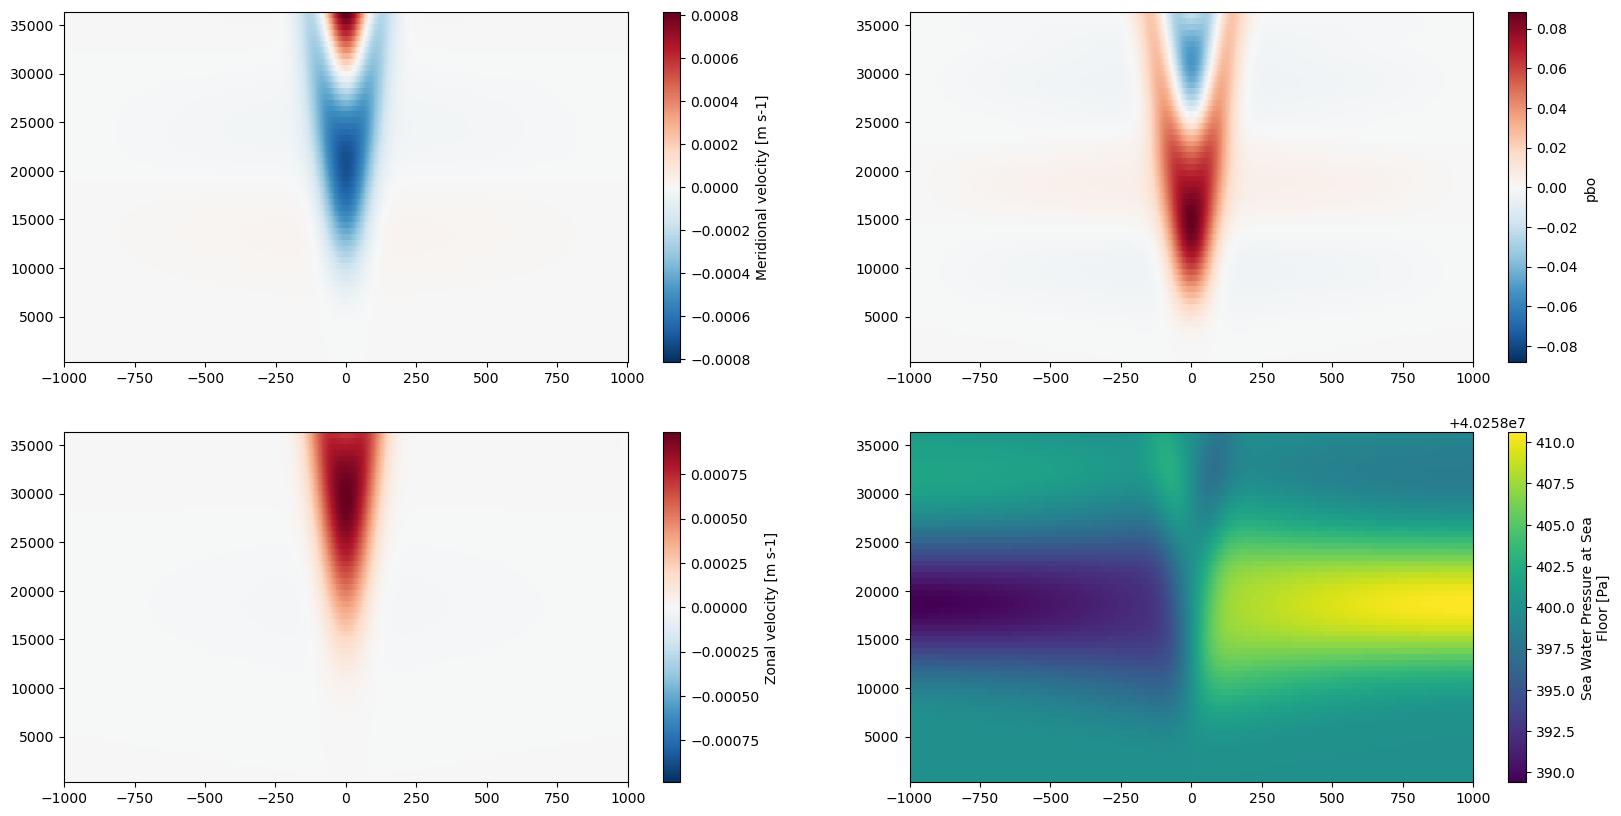

In [105]:
hours = 10

plt.figure()
fig,ax = plt.subplots(2,2,figsize = (20,10))
merid.v.isel(z_l = -1).sel(time = slice(0,3600 * hours)).plot(ax = ax[0,0])
merid.u.isel(z_l = -1).sel(time = slice(0,3600 * hours)).plot(ax = ax[1,0])
# merid.rho.sel(time = slice(0,3600 * hours)).integrate("z_l").plot(ax = ax[1,1])

merid.pbo.differentiate("yh").sel(time = slice(0,3600 * hours)).plot(ax = ax[0,1])
merid.pbo.sel(time = slice(0,3600 * hours)).plot(ax = ax[1,1])

for i in ax.flatten():
    i.set_title("")
    i.set_xlabel("")
    i.set_ylabel("")

# for 

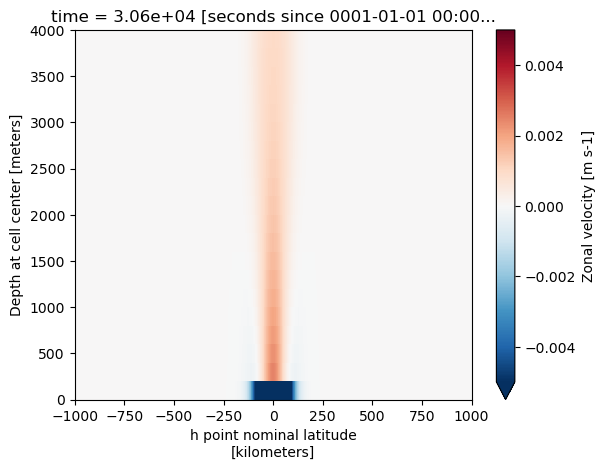

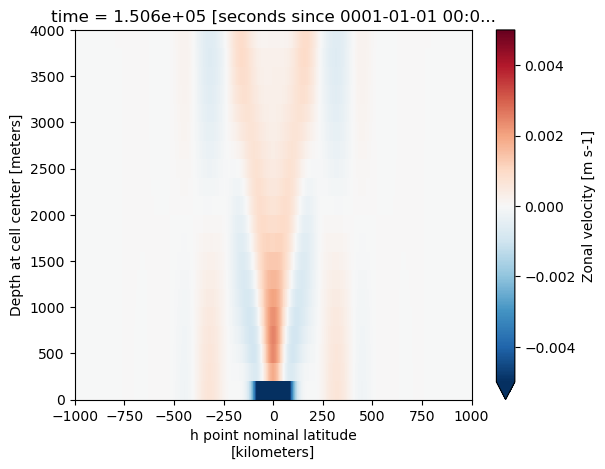

In [93]:
merid.u.isel(time = 50).plot(vmin = -0.005,vmax = 0.005,cmap = "RdBu_r")
plt.figure()
merid.u.isel(time = 50).plot(vmin = -0.005,vmax = 0.005,cmap = "RdBu_r")
plt.figure()
merid.u.isel(time = 250).plot(vmin = -0.005,vmax = 0.005,cmap = "RdBu_r")

## Make a vertical mode eigenfunction for pressure

$ \huge P_n = \cos\left(\frac{n \pi z}{H} \right) $

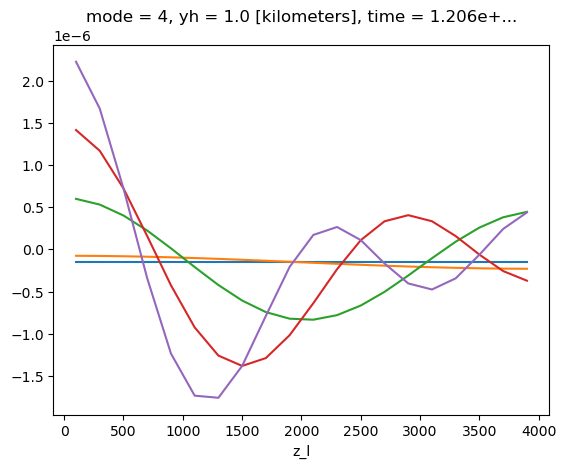

In [52]:
def vmode(data,nmodes = 5):
    modes_out = []
    eigfs = []
    for i in range(nmodes):
        eigf = xr.DataArray(
            np.cos(i * np.pi * data.z_l / 4000),
            dims = ["z_l"],
            coords = {"z_l":data.z_l.values})
        eigf /= (eigf**2).integrate("z_l")
        eigfs.append(eigf.expand_dims({"mode":[i]}))
        mode = (data * eigf).integrate("z_l")
        # mode /= 
        (modes_out).append(mode.expand_dims({"mode":[i]}))
        
    return xr.merge(
        [
            xr.concat(modes_out,dim = "mode").rename(data.name),
            xr.concat(eigfs,dim = "mode").rename("eigf")
        ]
    )

modes = vmode(merid.u.isel(yh  =500))

for i in range(5):
    (modes.u * modes.eigf).cumsum("mode").isel(mode = i,time = 200).plot()

merid.u.isel(yh = 500,time = 200).plot(color = "black")


<Figure size 640x480 with 0 Axes>

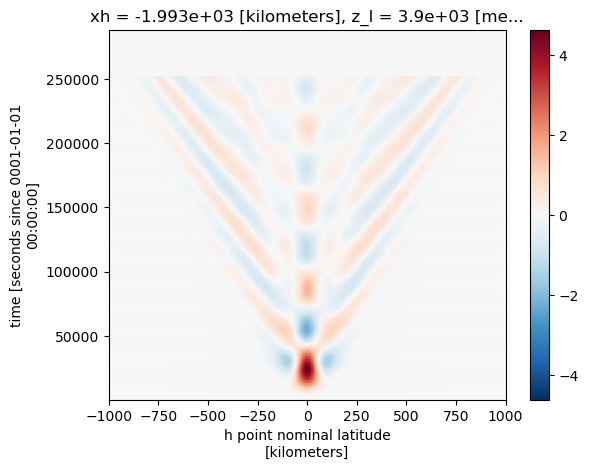

<Figure size 640x480 with 0 Axes>

In [14]:
pressure = (9.8 * 
            (
                200 * (merid.rho - merid.rho.isel(time=0, yh=0)) + 
                merid.e.isel(zi = 0) * 1025
                )
             ).cumsum("z_l")

pressure.isel(z_l = -1).differentiate("yh").plot()
plt.figure()
# pressure.differentiate("yhisel(yh = 500).plot()

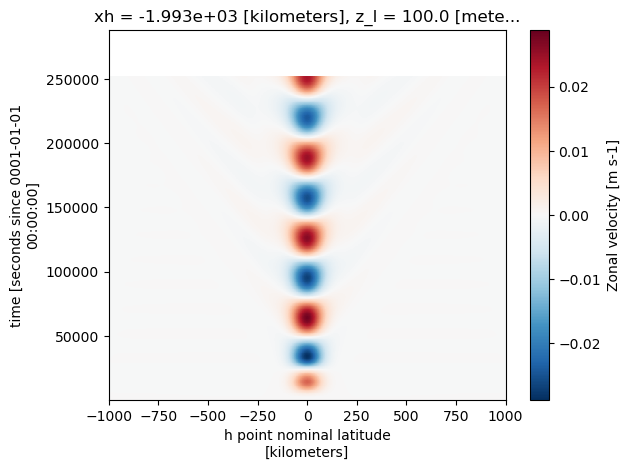

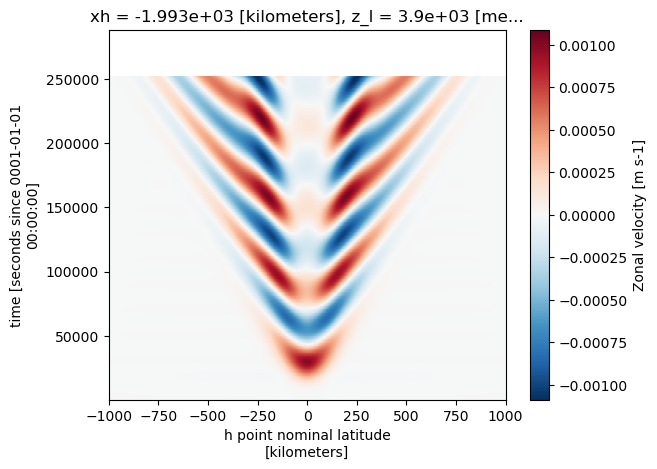

In [18]:
merid.u.isel(z_l = 0).plot()
plt.figure()
merid.u.isel(z_l = -1).plot()

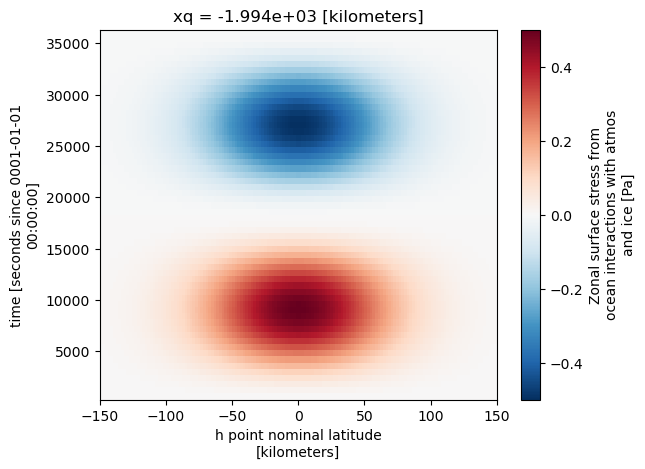

In [19]:
taux = xr.open_mfdataset(f"{basepath}/archive/output000/taux_10min.nc",decode_times = False).isel(xq = 3).taux.load()
taux.sel(yh = slice(-150,150)).plot()

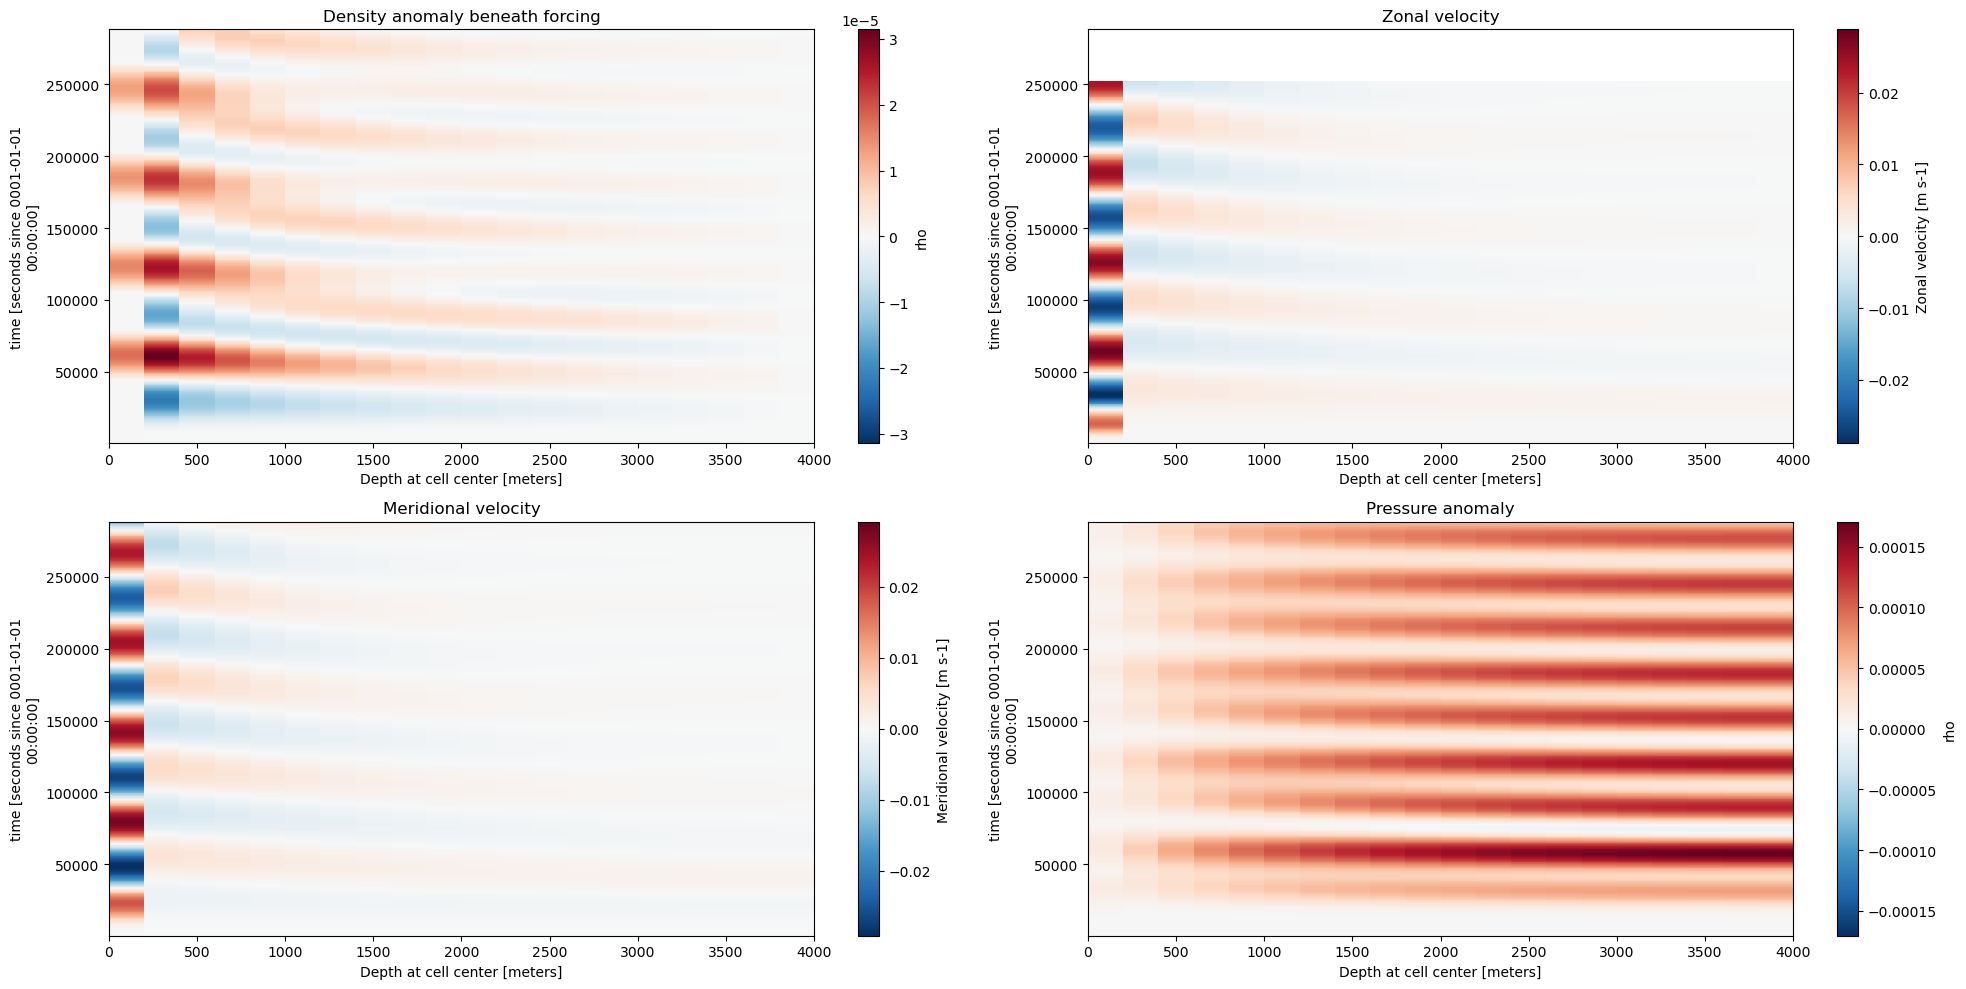

In [89]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

(merid.rho.isel(yh=500) - merid.rho.isel(time=0, yh=0)).plot(ax=axs[0, 0])
axs[0, 0].set_title("Density anomaly beneath forcing")

(merid.u.isel(yh=500)).plot(ax=axs[0, 1])
axs[0, 1].set_title("Zonal velocity")

(merid.v.isel(yq=500)).plot(ax=axs[1, 0])
axs[1, 0].set_title("Meridional velocity")

(pressure).plot(ax=axs[1, 1])
axs[1, 1].set_title("Pressure anomaly")

plt.tight_layout()
plt.show()


# (merid.rho.isel(yh = 491) - merid.rho.isel(time = 0,yh = 0)).plot()

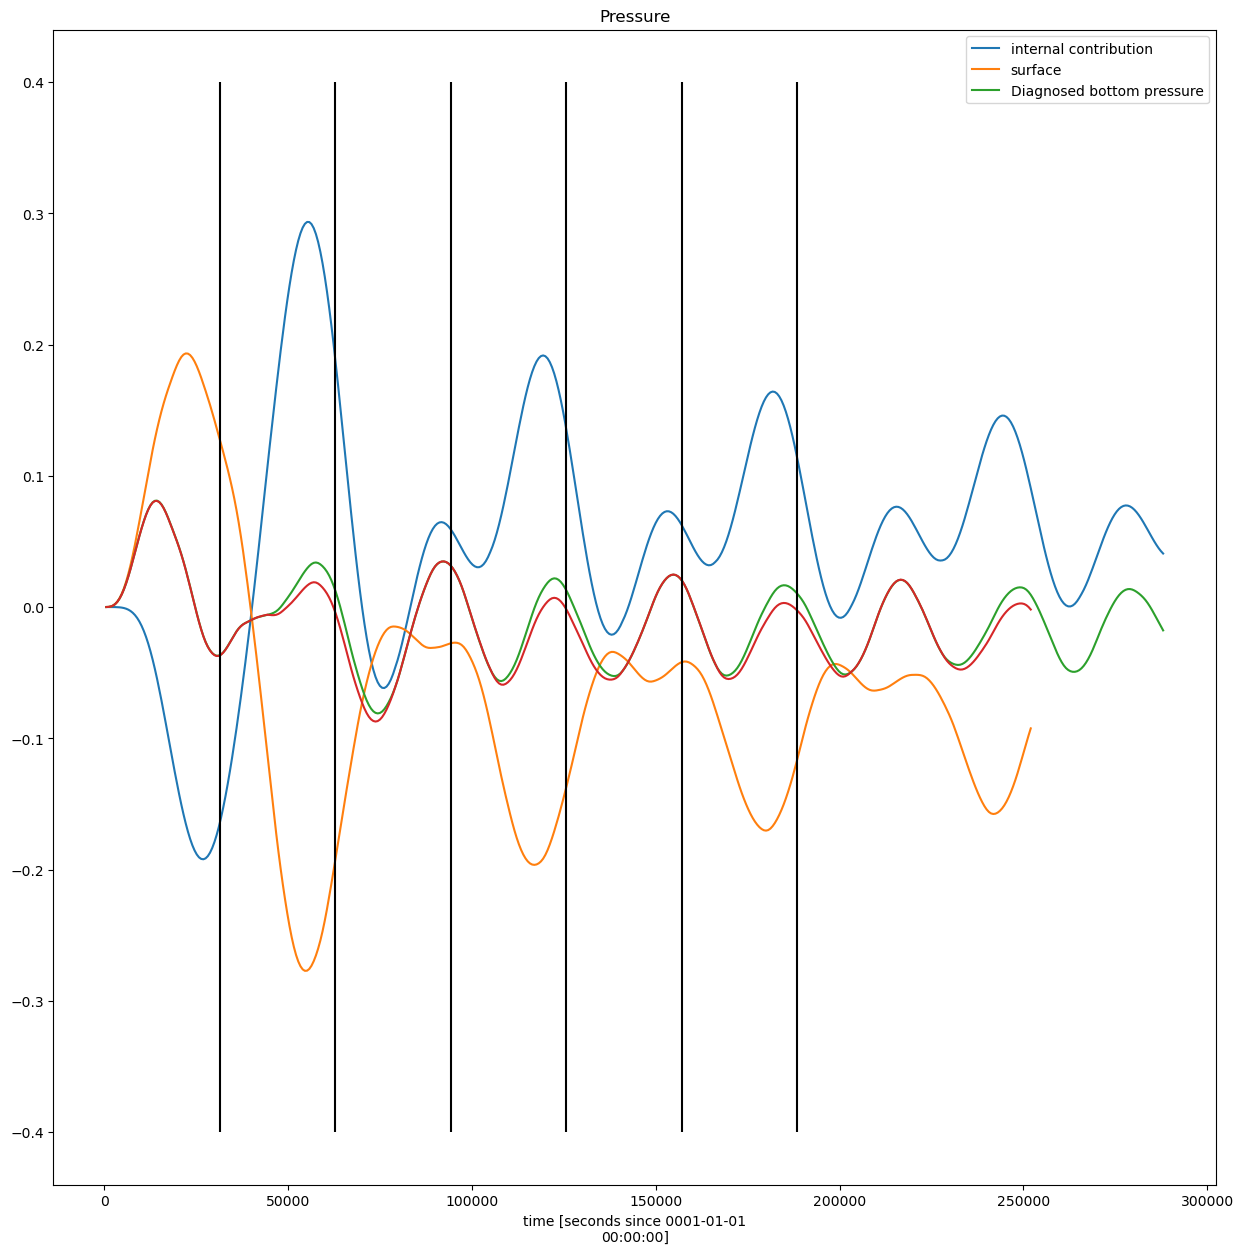

In [84]:
fig,ax = plt.subplots(1,figsize = (15,15))

pbo_internal = (9.8 *(merid.rho - merid.rho.isel(yh =0,time = 0))).integrate("z_l")
pbo_surface = (9.8 * 1025 * merid.e.isel(zi = 0))

pbo_internal.isel(yh = 500).plot(label = "internal contribution",ax = ax)
pbo_surface.isel(yh = 500).plot(label = "surface",ax = ax)
(merid.pbo - merid.pbo.isel(time = 0,yh = 0)).isel(yh = 500).plot(label = "Diagnosed bottom pressure",ax = ax)
(pbo_internal + pbo_surface).isel(yh = 500).plot(ax = ax)

ax.set_title("Pressure")

ax.legend()
ax.vlines(np.pi * 1e4,-0.4,0.4,color = "black")
ax.vlines(np.pi * 2e4,-0.4,0.4,color = "black")
ax.vlines(np.pi * 3e4,-0.4,0.4,color = "black")
ax.vlines(np.pi * 4e4,-0.4,0.4,color = "black")
ax.vlines(np.pi * 5e4,-0.4,0.4,color = "black")
ax.vlines(np.pi * 6e4,-0.4,0.4,color = "black")

In [121]:
f = -1 * np.pi * 2 / (17 * 3600)
f

-0.00010266642658790173

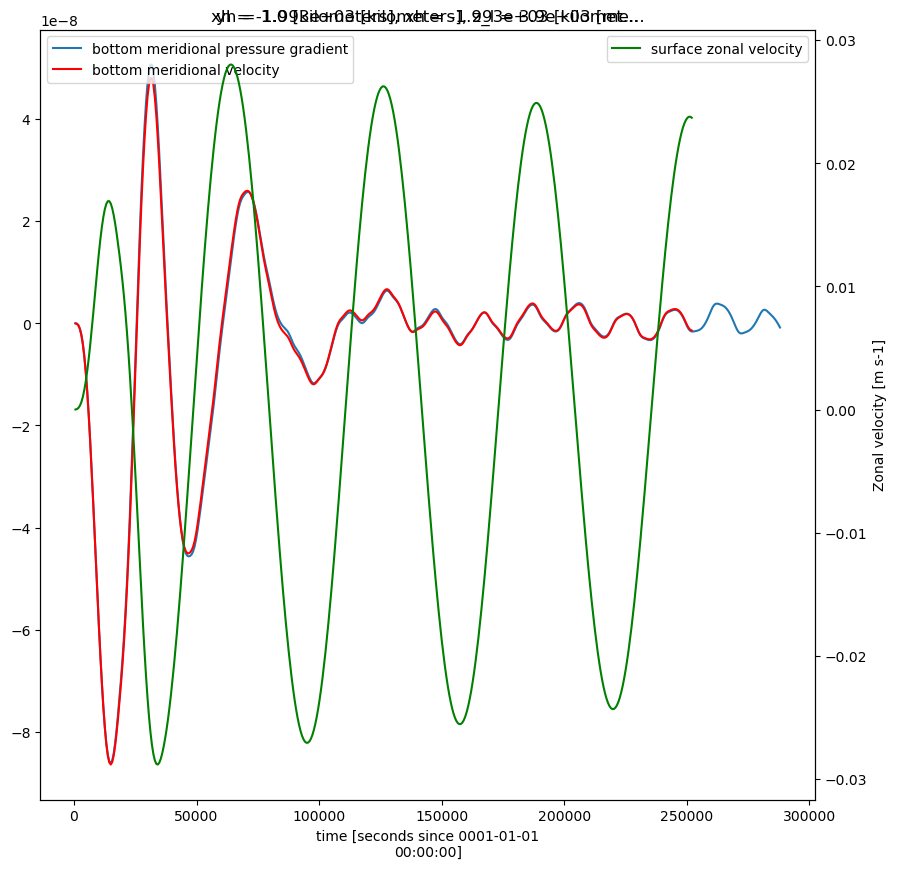

In [125]:

pbo_anom = (merid.pbo - merid.pbo.isel(time = 0,yh = 500)).assign_coords({"xh":merid.pbo.xh.values * 1000,"yh":merid.pbo.yh.values * 1000}) / 1025

# pbo_internal.differentiate("yh").isel(yh = 500).plot()
# pbo_surface.differentiate("yh").isel(yh = 500).plot()
fig,ax = plt.subplots(1,figsize = (10,10))
(-1 * pbo_anom.differentiate("yh")).isel(yh = 500).plot(label = "bottom meridional pressure gradient")
# (merid.pbo - merid.pbo.isel(time = 0,yh = 0)).differentiate("yh").isel(yh = 490).plot(label = "bottom meridional pressure gradient")
# (merid.pbo - merid.pbo.isel(time = 0,yh = 0)).differentiate("yh").isel(yh = 495).plot()
# (pbo_internal + pbo_surface).differentiate("yh").isel(yh = 500).plot(ax = ax)
ax2 = ax.twinx()
(merid.v.isel(yq = 500,z_l = -1).differentiate("time") + f * merid.u.isel(yh = 500,z_l = -1)).plot(ax = ax,color = "red",label = "bottom meridional velocity")
merid.u.isel(yh = 500,z_l = 0).plot(ax = ax2,color = "green",label = "surface zonal velocity")
ax.legend(loc = "upper left")
ax2.legend()


In [ ]:

pbo_anom = (merid.pbo - merid.pbo.isel(time = 0,yh = 500)).assign_coords({"xh":merid.pbo.xh.values * 1000,"yh":merid.pbo.yh.values * 1000}) / 1025

# pbo_internal.differentiate("yh").isel(yh = 500).plot()
# pbo_surface.differentiate("yh").isel(yh = 500).plot()
fig,ax = plt.subplots(1,figsize = (10,10))
(pbo_anom.differentiate("xh")).isel(yh = 500).plot(label = "bottom meridional pressure gradient")
# (merid.pbo - merid.pbo.isel(time = 0,yh = 0)).differentiate("yh").isel(yh = 490).plot(label = "bottom meridional pressure gradient")
# (merid.pbo - merid.pbo.isel(time = 0,yh = 0)).differentiate("yh").isel(yh = 495).plot()
# (pbo_internal + pbo_surface).differentiate("yh").isel(yh = 500).plot(ax = ax)
# ax2 = ax.twinx()
(merid.v.isel(yq = 500,z_l = -1).differentiate("time") + f * merid.u.isel(yh = 500,z_l = -1)).plot(ax = ax,color = "red",label = "bottom meridional velocity")

ax.legend(loc = "upper left")



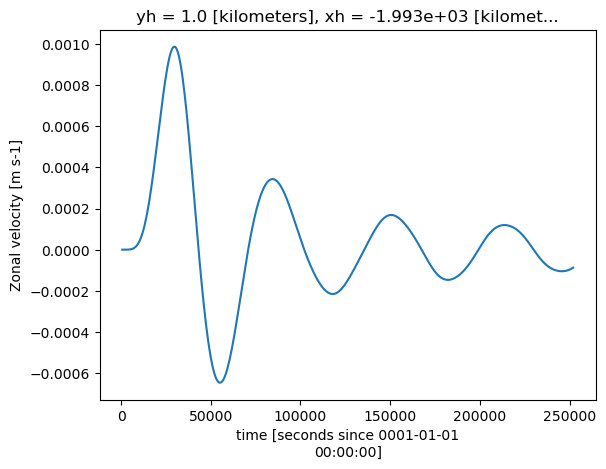

In [18]:
merid.u.isel(yh = 500,z_l = -1).plot()

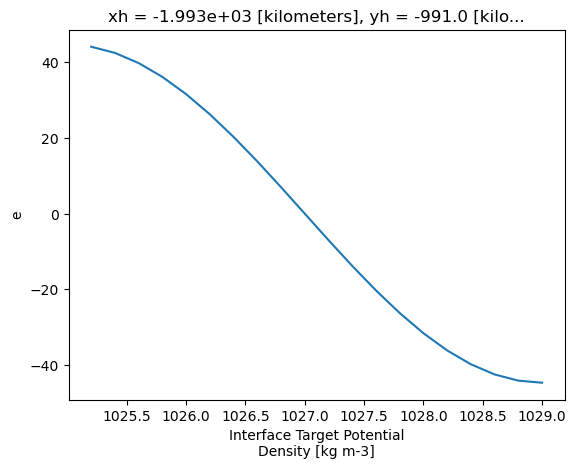

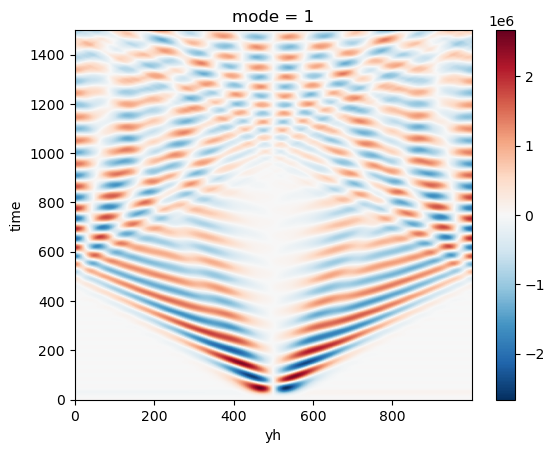

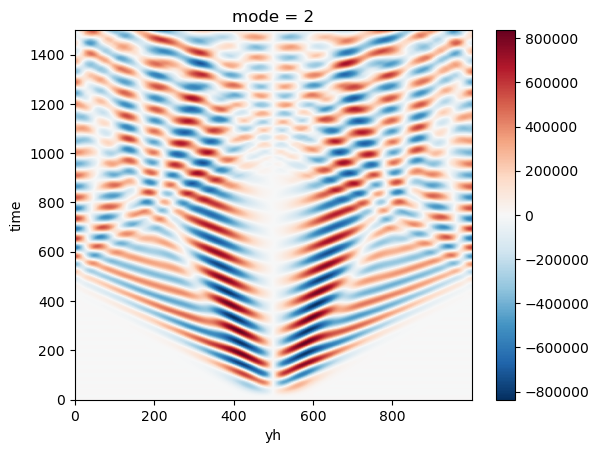

In [18]:
def vmodeU(p,e):
    """
    Pressure is on isopycnal coordinates. When decomposing onto vertical modes, we regrid onto the z coordinate. 
    """

    modes = []

    for i in range(1,6):
        efunc = np.sqrt(4000/2) * np.cos(np.pi * i * e.isel(zi = slice(1,None)) / 4000).rename({"zi":"zl"})

        modes.append(
            xr.DataArray(
                (efunc * p).values * e.diff("zi").values, ## Hack job at integrating in z*
                dims = p.dims
            ).expand_dims({"mode":[i]}).sum("zl")
        )

    efunc = np.sqrt(4000/2) * np.cos(np.pi * 1 * e.isel(zi = slice(1,None)) / 4000).rename({"zi":"zl"})
    efunc.isel(yh = 4,time = 50).plot()
    plt.figure()
    p.isel(yh = 4,time = 50).plot()
    p.isel(yh = 4,time = 51).plot()

    return xr.concat(modes,dim = "mode")
        

vmodes = vmodeU(merid_p,merid.e)
vmodes.isel(mode = 0).plot()
plt.figure()
vmodes.isel(mode = 1).plot()


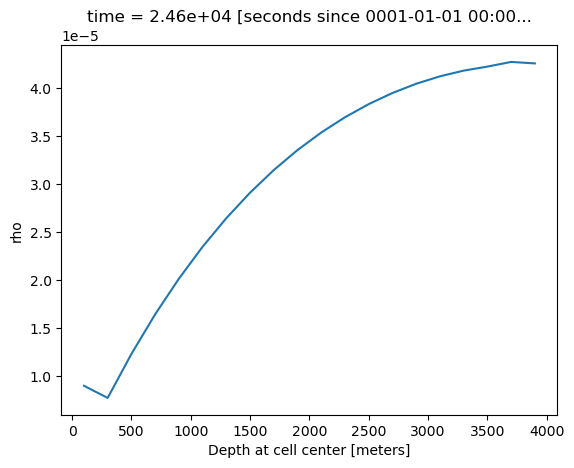

In [98]:
pressure.isel(time = 40).plot()

# Use zstar outputs instead!

In [ ]:
def PressureZstar(rho,eta):
    """
    Calculates the pressure at the base of each layer. This means the first value is at 200, the last is at 4000.

    Uses z* rho, and the surface displacement eta.

    Expects inputs to be slices with only one horizontal dimension    
    """
    if "yh" in rho.dims:
        x = "yh"
    else:
        x = "xh"

    rho0 = rho.isel({"time":0,x:0})
    surface_contribution = 9.8 * eta * rho0.isel(zl = 0)

    pressure  = rho * 0 + surface_contribution

    for i,z in enumerate(rho.zl.values):
        ## Iterate over every layer
        pressure.iloc[pressure.zl == z] = 9.8 * (rho.isel(zl = i) - rho0) * 200 # P' = g * rho' * h

    pressure.iloc[pressure.zl == 0] += surface_contribution

    pressure = pressure.cumsum("zl")

       
    
    
    return pressure

merid_p = calculate_pressure_new(merid.e,merid.zl)

In [7]:
(2* np.pi / f ) / 3600

17.453292519943293

## Calculate omega from our k

In [3]:
import numpy as np
k = np.pi * 2 / 150000   # Storm witdh in m
f = 1e-4                 # Coriolis frequency s.t 2pi / f = 17hrs
N = 20 * f               # Buoyancy frequency
H = 4000                 # Depth in m
omega1 = np.sqrt(        # Frequency of mode 1 from dispersion relation
    f**2 + 
    (H**2 * k**2 * N**2) / np.pi**2
    )
omega2 = np.sqrt(        # Frequency of mode 2 from dispersion relation
    f**2 + 
    (H**2 * k**2 * N**2) / (4 * np.pi**2)
    )

T = np.pi / (            # T is dephasing time in seconds. T = pi / (omega1 - omega2)
    omega1 - omega2
    )    

print(T / 3600)          # Convert to hours

26.542443801540756
